# IFT6269 - Homework 4 - Hidden Markov Models
**Due:**  Thursday, November 28, 2024


#### Name: Grégoire Barrette    
#### Student ID: 20175180
#### Collaborators: None



## Introduction

The file `EMGaussian.train` contains samples of data $\{x_t\}_{t=1}^T$ where $x_t \in \mathbb{R}^2$, with one datapoint per row. `EMGaussian.test` is structured similarly. This is the same data we used in Homework 3, but this time we use an HMM model to account for the possible temporal structure of the data. This means that we now consider each row of the dataset to be a point $x_t \in \mathbb{R}^2$ corresponding to some temporal process, rather than thinking of them as *independent* samples as we did in the last homework.

We consider the following HMM model: the chain $(z_t)_{t=1}^T$ has  $K=4$ possible states, with an initial probability distribution $\pi\in\Delta_4$ and a probability transition matrix  $A \in \mathbb{R}^{4 \times 4}$ where $A_{ij} = p(z_t=i | z_{t-1} = j),$ and conditionally on the current state $z_t$, we have observations obtained from Gaussian emission probabilities $x_t| (z_t=k) \sim \mathcal{N}(x_t | \mu_k, \Sigma_k)$.  This is thus a generalization of a GMM since we now allow for time dependencie across the latent states $z_t$.

This exercise has several implementation objectives:
* **Sum-product**: probabilistic inference on the HMM
* **Expectation-Maximization**: parameter estimation
* **Viterbi**: decoding.

**Note:** You may use the (*possibly corrected*) code you created for the previous assignment. Furthermore, notice there are some math questions in this notebook: do not forget to solve them!

### Tasks
0.   Get your own copy of this file via "File > Save a copy in Drive...",
1.   Fill your personal information and collaborators at the top of this assignment, and rename the notebook accordingly, e.g., `hw4_thomasBayes.ipynb`
2.   Read the instructions provided on each section and cell carefully,
3.   Complete the exercises in the sections **Sum-product**, **Expectation-Maximization**, **Viterbi**, **Comparing methods** and **What about K?**.
4.   Share your notebook with `ift6269.f23@gmail.com` ("Share" button on the top-right corner);
5.   Share the link of your notebook on Gradescope ("Share > Copy Link", and paste the link in "Homework 4 (Programming & Checklist)" on Gradescope).
    
**Important**: You are allowed to collaborate with other students in both the math and coding parts of this assignment. However, the answers provided here must reflect your individual work. For that reason, you are not allowed to share this notebook, except for your submission to the TA for grading. **Don't forget to pin and save the version of the notebook you want to be graded on!**

**Important**: Your are allowed to use functions **only** from the libraries imported here (`numpy` and `matplotlib`). In particular (but not limited to), you are **not allowed** to import functions from `scipy`.

In [1]:
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set_style("white")

X_train = np.loadtxt("hwk3data/EMGaussian.train")
X_test = np.loadtxt("hwk3data/EMGaussian.test")

## Playground

You are allowed to add as many cells and functions as you wish in this section, but not allowed to change the signature (name and inputs) of the functions we provided!

In [2]:
# ---------------------------------------------------------------------------
#                       Code for plotting the results
#                      ! DO NOT MODIFY THESE FUNCTIONS !
# ---------------------------------------------------------------------------

def plot_smoothing(gamma, K=4, time_limit=100):
    plt.figure(figsize=(14, 2*K))
    plt.suptitle('Smoothing probabilities $p(z_t|x_1, ..., x_T)$', fontsize=16)
    for k in range(K):
        plt.subplot(K, 1, 1+k)
        plt.plot(range(1, time_limit+1), gamma[:time_limit, k] )
        plt.ylabel(r'$p(z_t = ' + str(k+1) + ' | x_{1:T})$')
        plt.ylim(0, 1)
        plt.grid(True)
    plt.xlabel('t')
    # plt.show()

def plot_labelling(X, labels, mus, title=""):
    shapes = ['o', '*', 'v', '+']
    colors = [[31, 119, 180], [255, 127, 14], [44, 160, 44], [148, 103, 189],
              [140, 86, 75], [227, 119, 194], [127, 127, 127], [188, 189, 34]]

    fig = plt.figure(figsize=(5, 5))
    cs = [colors[int(_) % len(colors)] for _ in labels]
    plt.scatter(X[:, 0], X[:, 1], c=np.array(cs)/255.)
    plt.scatter(mus[:, 0], mus[:, 1], marker='o', c='#d62728')
    plt.xlim(-12, 12), plt.ylim(-12, 12)
    plt.title(title, fontsize=16)
    plt.show()

def plot_dominoes(data):
    # Pick max from data per timestep
    data_maxhot = (data == data.max(axis=1, keepdims=True))

    fig, ax = plt.subplots()
    fig.set_size_inches(12, 3)
    ax.pcolor(1 - data_maxhot[:100,::-1].T, cmap=plt.cm.gray, alpha=0.6)
    ax.set_yticks(np.arange(4) + 0.5, minor=False)
    ax.set_yticklabels([4,3,2,1], minor=False)
    plt.grid(True)
    plt.tight_layout()

    plt.show()

## Sum-product [15 pts]

### $\alpha$, $\beta$ recursions

Implement the $\alpha$ and $\beta$-recursions seen in class (and that can be found in chapter 12 of Mike's book with slightly different notation). Recall that $\alpha(z_t) := p(z_t, x_{1:t})$, $\beta(z_t) := p(x_{(t+1):T} | z_t)$. Implement also a function to compute the emission probabilties $\epsilon_k(x_t) := p(x_t|z_t=k) = \mathcal{N}(x_t|\mu_k, \Sigma_k)$.

For numerical stability reasons, you are expected to implement your algorithms using **log probabilities** unless noted explicitly!



In [3]:
def log_sum_exp(log_probs):
    """
    Log-sum-exp trick for numerical stability

    Inputs:
        log_probs: log of probabilities to sum over
    Returns:
        sum over log_probs with no numerical underflow/overflow (hopefully!)
    """
    max = np.max(log_probs)
    return max + np.log(np.sum(np.exp(log_probs - max)))

def log_emission(X, mus, sigmas) :
    """
    (Log) probabilities under a Gaussian emission model for a time-homogeneous HMM

    Inputs:
        X: [Tx2] matrix of observations
        mus: [Kx2] matrix of latent-conditional emission means
        sigmas: [Kx2x2] tensor of latent-conditional emission covariance matrices

    Returns:
        log_eps: [TxK] matrix of log emission probabilities: log p(x_t | z_t = k)
    """
    T, d, K = X.shape[0], X.shape[1], mus.shape[0]

    log_eps = np.zeros((T,K))

    # compute the determinant and the inverse of the covariances only once
    sigmas_det = np.linalg.det(sigmas)
    sigmas_inv = np.linalg.inv(sigmas)

    for k in range(K):
        norm = -(d/2) * np.log(2*np.pi) - 0.5 * np.log(sigmas_det[k]) # gaussian normalization factor
        
        for t in range(T):
            dist = X[t].T - mus[k].T
            log_eps[t, k] = -0.5 * (dist.T @ sigmas_inv[k] @ dist) + norm

    return log_eps

def log_alpha_recursion(X, A, log_eps, pi) :
    """
    (Log) alpha recursion for a time-homogeneous HMM with Gaussian emissions

    Inputs:
        X: [Tx2] matrix of observations
        A: [KxK] transition matrix
        log_eps: [TxK] matrix of log emission probabilities: log p(x_t | z_t = k)
        pi: [Kx1] initial latent state distribution

    Returns:
        log_alpha: [TxK] vector containing log p(z_t , x_{1:t})
    """
    T, K = log_eps.shape

    log_alpha = np.zeros((T, K))
    
    for t in range(T):
        for k in range(K):
        
            # base case: log p(z_1, x_1) = log p(x_0|z_0) + log \pi
            if t==0:
                log_alpha[t, k] = log_eps[t, k] + np.log(pi[k])
            # log p(z_t, x_{1:t})
            else:
                log_alpha[t, k] = log_eps[t, k] + log_sum_exp(log_alpha[t-1, :] + np.log(A[:, k]))

    return log_alpha

def log_beta_recursion(X, A, log_eps) :
    """
    (Log) beta recursion for a time-homogeneous HMM with Gaussian emissions

    Inputs:
        X: [Tx2] matrix of observations
        A: [KxK] transition matrix
        log_eps: [TxK] matrix of log emission probabilities: log p(x_t | z_t = k)

    Returns:
        log_beta: [TxK] vector containing log p(x_{t+1:T} | z_t)
    """

    T, K = log_eps.shape

    log_beta = np.zeros((T,K))

    for t in reversed(range(T)):
        for k in range(K):

            # base case
            if t == T-1:
                log_beta[t,:] = 0

            else:
                log_beta[t, k] = log_sum_exp(log_beta[t+1, :] +  np.log(A[k, :]) + log_eps[t+1, :])

    return log_beta

Using the two functions above, implement the computation of the *smoothing* distribution $p(z_t|x_1,\dots,x_T)$ and pair-marginals $p(z_t,z_{t+1}|x_1,\dots,x_T)$. Here use log probabilities from the $\alpha$ and $\beta$, but return a normal (not log!) probability, i.e, a number in $[0,1]$.

In [ ]:
def smoothing(log_alpha, log_beta):
    """
    Smoothing probabilities for a time-homogeneous HMM with Gaussian emissions

    Inputs:
        log_alpha: [TxK] matrix containing log p(z_t , x_{1:t})
        log_beta: [TxK] matrix containing log p(x_{t+1:T} | z_t)

    Returns:
        gamma: [TxK] matrix of smoothing probabilities p(z_t | x_{1:T})
    """
    T, K = log_alpha.shape
    gamma = np.zeros((T, K))
    
    for t in range(T):
        log_gamma = log_alpha[t, :] + log_beta[t, :]
        log_gamma -= log_sum_exp(log_gamma) # normalization
        gamma[t, :] = np.exp(log_gamma)

    return gamma

def pair_marginals(log_alpha, log_beta, A, log_eps):
    """
    Pair marginals for a time-homogeneous HMM with Gaussian emissions

    Inputs:
        log_alpha: [TxK] matrix containing log p(z_t , x_{1:t})
        log_beta: [TxK] matrix containing log p(x_{t+1:T} | z_t)
        A: [KxK] transition matrix
        log_eps: [TxK] matrix of log emission probabilities: log p(x_t | z_t = k)

    Returns:
        psi: [T-1xKxK] numpy tensor of pair marginal probabilities p(z_t, z_{t+1} | x_{1:T})
    """

    T, K = log_alpha.shape
    log_psi = np.zeros((T-1, K, K))

    for t in range(1,T):
        for i in range(K):
            for j in range(K):
                log_psi[t-1, j, i] = log_alpha[t-1, i] + log_eps[t, j] + np.log(A[i,j]) + log_beta[t, j]

        log_psi[t-1, ...] -= log_sum_exp(log_psi[t-1,...]) # normalization

    psi = np.exp(log_psi)
    return psi


### Inference with ad hoc parameters

Consider using the same parameters for the means and covariance matrix of the 4 Gaussians that you should have learned in Homework 3 for EM with general covariance matrices. For convenience, we give to you below:
\begin{align*}
\mu_1 &= \left( \begin{aligned}
-2&.0344 \\
4&.1726
\end{aligned}
\right) &
\mu_2 &= \left( \begin{aligned}
3&.9779 \\
3&.7735
\end{aligned}
\right) &
\mu_3 &= \left( \begin{aligned}
3&.8007 \\
-3&.7972
\end{aligned}
\right) &
\mu_4 &= \left( \begin{aligned}
-3&.0620 \\
-3&.5345
\end{aligned}
\right) &
\end{align*}

\begin{align*}
\Sigma_1 &= \left( \begin{aligned}
2&.9044 &   0&.2066 \\
0&.2066 &   2&.7562
\end{aligned}
\right) &
\Sigma_2 &= \left( \begin{aligned}
0&.2104 &   0&.2904 \\
0&.2904 &   12&.2392
\end{aligned}
\right)
\\
\\
\Sigma_3 &= \left( \begin{aligned}
0&.9213 &   0&.0574 \\
0&.0574 &   1&.8660
\end{aligned}
\right) &
\Sigma_4 &= \left( \begin{aligned}
6&.2414 &   6&.0502 \\
6&.0502 &   6&.1825
\end{aligned}
\right)
\end{align*}



Consider a uniform initial probability distribution $\pi_k = \frac{1}{4}$, and set $A$ to be the matrix with diagonal coefficients $A_{ii}=\frac{1}{2}$ and off-diagonal coefficients $A_{ij}=\frac{1}{6}$ for all $(i,j) \in \{1,\ldots,4\}^2$.

In [5]:
# We have already typed in all these wonderful numbers for you ;)
K = 4

pi = np.array(4 * [1/4])

A = (1/2) * np.eye(4) + (1/6) * (np.ones(4) - np.eye(4))

mus = np.array([[-2.0344, 4.1726], \
                      [3.9779 , 3.7735], \
                      [3.8007 ,-3.7972], \
                      [-3.0620,-3.5345]])

sigmas = np.array([[[2.9044, 0.2066],[0.2066, 2.7562 ]],  \
                   [[0.2104, 0.2904],[0.2904, 12.2392]],  \
                   [[0.9213, 0.0574],[0.0574, 1.8660 ]],  \
                   [[6.2414, 6.0502],[6.0502, 6.1825 ]]])

# We store this for EM later
INIT_PARAMS = (K, pi, A, mus, sigmas)

Let $\{x_1,\dots,x_T\}$ be the **test** data. Using your functions above, for all $t$ on the test data, compute $\log(\alpha_t)$, $\log(\beta_t)$ and  $p(z_t | x_1,\dots,x_T)$. Finally, plot $p(z_t|x_1,\dots,x_T)$ for each of the 4 states as a function of $t$ for the first 100 timesteps.

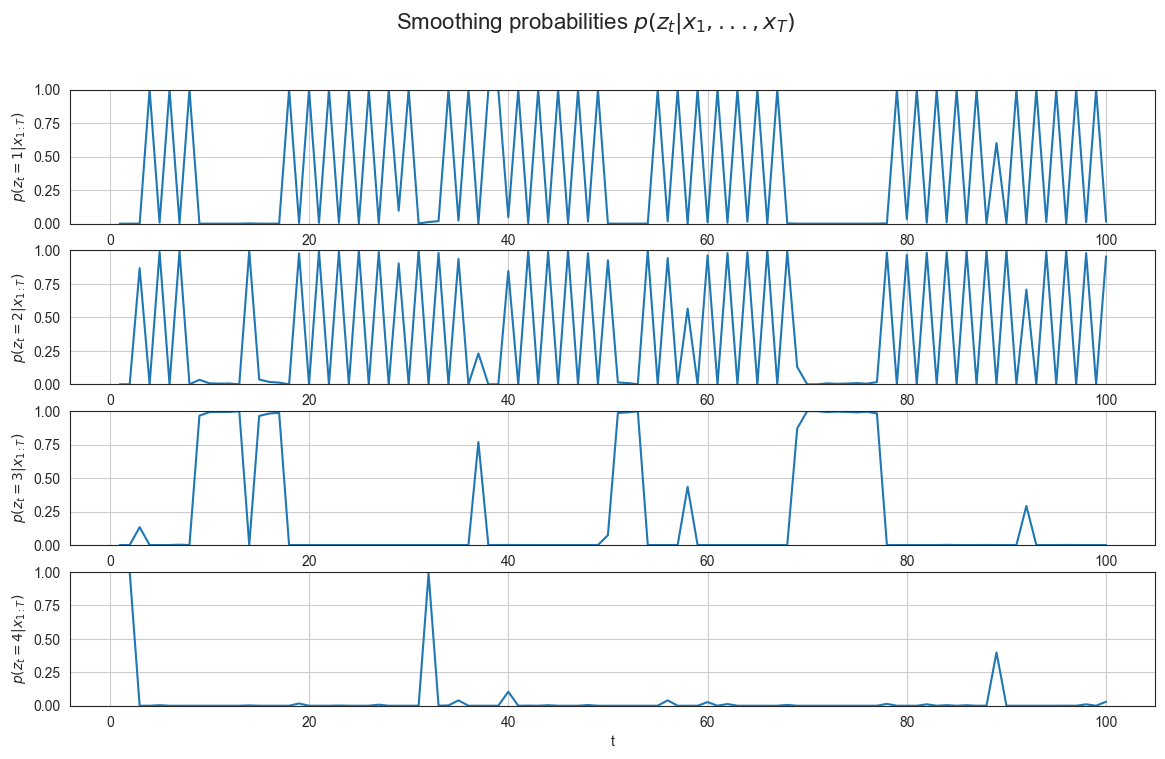

In [6]:
# ---------------------------------------------------------------------------- #
#     Do NOT change the contents of this cell. This is just for execution.     #
#   If you respected function signatures, this cell should run without changes #
# ---------------------------------------------------------------------------- #

# Compute emission (log) probabilities
log_eps = log_emission(X_test, mus, sigmas)
assert log_eps.shape == (X_test.shape[0], K), "Erroneous shape of `log_eps`"
assert np.all(log_eps <= 0), "Erroneous domain for log p(x_t|z_t)"

# Perform (log) alpha and beta recursions
log_alpha = log_alpha_recursion(X_test, A, log_eps, pi)
log_beta = log_beta_recursion(X_test, A, log_eps)

assert np.allclose(log_alpha[0], [-19.91, -197.75, -42.54, -3.85], rtol=1e-1), "Erroneous initial condition for alpha recursion"
assert np.allclose(log_beta[-1], 0), "Erroneous boundary condition for beta recursion"

# Compute smoothing probabilities
gamma = smoothing(log_alpha, log_beta)
assert np.allclose(gamma.sum(axis=1), 1), "`gamma` is not a probability distribution"

# Now we do the plot of the smoothing probability for each of the 4 states
plot_smoothing(gamma)

# Edge maringals, for the assert below
psi = pair_marginals(log_alpha, log_beta, A, log_eps)

assert np.allclose(psi.sum(axis=(1,2)), 1), "`psi` must be a distribution over z_t, z_{t+1} pairs for every x_t"
assert np.allclose(gamma[1:], psi.sum(axis=(2))), "`gamma` should correspond to the marginal of `psi` over z_{t+1}"

## Expectation-Maximization [20 pts]

### M-step updates
Derive the M-step update for $\hat{\pi}$, $\hat{A}$, $\hat{\mu}_k$ and $\hat{\Sigma}_k$ (for $k=1,\ldots, 4)$ during the EM algorithm, as a function of the quantities computed during the E step. Note that for the estimate of $\pi$, we only have *one* long chain here!

**Answer:**

The log likelihood of the HMM model is 
\begin{align}
\log p(x, z|\theta) &= \log\left(p(z_1|\pi)\prod_{t=1}^Tp(x_t|z_t)\prod_{t=2}^Tp(z_t|z_{t-1})   \right)\\
&=\left( \prod_{k=1}^K\pi_k^{z_1^k}\prod_{t=1}^T\prod_{k=1}^K\mathcal{N}(x_t|\mu_k, \Sigma_k)^{z_t^k}\prod_{t=2}^T\prod_{i,j=1}^KA_{ij}^{z_{t-1}^iz_t^j}\right)\\
&= \sum_{k=1}^Kz_1^k\log\pi_k +\sum_{t=1}^T\sum_{k=1}^Kz_t^k\log\mathcal{N}(x_t|\mu_k,\Sigma_k)+\sum_{t=2}^T\sum_{i,j=1}^K(z_{t-1}^iz_t^j)\log A_{ij}\\
&= \sum_{k=1}^K\gamma_1^k\log\pi_k +\sum_{t=1}^T\sum_{k=1}^K\gamma_t^k\log\mathcal{N}(x_t|\mu_k, \Sigma_k)+\sum_{t=2}^T\sum_{i,j=1}^K\psi_{t-1, t}^{ij}A_{ij}\\
\end{align}
In final step, I used the quantities computed during the E step, namely $\gamma$ and $\psi$. First, maximize $\log p(x,z|\theta)$ with respect to $\pi_k$ under the constraint that $\sum_{k=1}^K\pi_k =1$. The Lagrangian is
\begin{equation}
\mathcal{L} = \log p(x,z|\theta) - \lambda g(\pi)
\end{equation}
where
\begin{equation}
g(\pi)\equiv \sum_{k=1}^K\pi_k -1 = 0
\end{equation}
is the constraint. Now to extremize the Lagrangian:
\begin{align}
\frac{\partial\mathcal{L}(\theta, \lambda)}{\partial \pi_\ell} &= \frac{\partial}{\partial\pi_\ell}\left(\sum_{k=1}^K\gamma_1^k\log\pi_k-\lambda\left(\sum_{k=1}^K\pi_k-1\right)\right) = 0\\
&\implies\frac{\gamma_1^\ell}{\pi_\ell} -\lambda = 0\\
&\implies \pi_\ell = \frac{\gamma_1^\ell}{\lambda}
\end{align}
Going back to the constraint:
\begin{align}
\sum_{k=1}^K\pi_k &= 1 \\
\sum_{k=1}^K\frac{\gamma_1^k}{\lambda} &= 1 \implies \lambda = \sum_{k=1}^K\gamma_1^k.
\end{align}
So the M step for $\pi_\ell$ is
\begin{equation}
\hat{\pi}_\ell = \frac{\gamma_1^\ell}{\sum_{k=1}^K\gamma_1^k}.
\end{equation}
Now for $A_{ij}$ under the constraint that $\sum_{i=1}^K A_{ij} =1$. The Lagrangian is
\begin{equation}
\mathcal{L}(\theta, \lambda) = \log p(x, z|\theta) - \lambda\sum_{i=1}^K\left(A_{ij}-1\right).
\end{equation}
Extremize this with respect to $A_{k\ell}$
\begin{align}
\frac{\partial \mathcal{L}(\theta, \lambda)}{\partial A_{k\ell}} &= \frac{\partial}{\partial A_{k\ell}}\left(\log p(x, z|\theta) - \lambda\sum_{i=1}^K\left(A_{ij}-1\right)\right) = 0\\ 
&\implies \frac{\partial}{\partial A_{k\ell}}\left(\sum_{t=2}^T\sum_{i,j=1}^K\psi_{t-1,t}^{ij}A_{ij}- \lambda\sum_{i=1}^K\left(A_{ij}-1\right)\right) = 0\\
&\implies \frac{1}{A_{k\ell}}\sum_{t=2}^T\psi_{t-1, t}^{k\ell}-\lambda = 0\\
&\implies A_{k\ell} = \frac{\sum_{t=2}^T\psi_{t-1,t}^{k\ell}}{\lambda}.
\end{align}
Going back to the contraint
\begin{align}
\sum_{i=1}^KA_{ij} = 1\\
\sum_{i=1}^K\frac{\sum_{t=2}^T\psi_{t-1,t}^{ij}}{\lambda} &= 1\\
\implies \lambda = \sum_{i =1}^K\sum_{t=2}^T&\psi_{t-1, t}^{ij}.
\end{align}
So the M step for $A_{k\ell}$ is
\begin{equation}
\hat{A}_{k\ell} = \frac{\sum_{t=2}^T\psi_{t-1, t}^{k\ell}}{\sum_{t=2}^T\sum_{i=1}^K \psi_{t-1,t}^{ij}}
\end{equation}
Now, to maximize $\log p(x,z|\theta)$ with respect to $\mu_\ell$:
\begin{align}
\frac{\partial\log p(x, z|\theta)}{\partial\mu_\ell} &= \frac{\partial}{\partial\mu_\ell}\sum_{t=1}^T\sum_{k=1}^K\gamma_t^k\log\mathcal{N}(x_t|\mu_k,\Sigma_k) =0\\
&\implies \frac{1}{2}\sum_{t=1}^T\frac{\partial}{\partial\mu_\ell}\sum_{k=1}^K\gamma_t^k(x_t-\mu_k)^T\Sigma_k^{-1}(x_t-\mu_k) = 0\\
\end{align}
Using $\frac{\partial}{\partial x} x^TAx = \frac{1}{2}(A^t+A)x$ and the fact that $\Sigma_k^{-1}$ is symmetric because it is a covariance matrix, I get
\begin{align}
\sum_{t=1}^T\gamma_t^\ell\Sigma_\ell^{-1}(x_t-\mu_\ell) &= 0\\
\implies \mu_\ell\sum_{t=1}^T\gamma_t^\ell = \sum_{t=1}^T\gamma_t^\ell x_t.
\end{align}
So the M step for $\mu_\ell$ is
\begin{equation}
\hat{\mu}_\ell = \frac{\sum_{t=1}^T\gamma_t^\ell x_t}{\sum_{t=1}^T\gamma_t^\ell}.
\end{equation}
Lastly, for the covariance matrix $\Sigma_\ell$, let me parametrize the Gaussian in terms of the precision matrix $\Lambda_\ell\equiv\Sigma_\ell^{-1}$. To maximize $\log p(x, z|\theta)$ with respect to $\Lambda_\ell$:
\begin{align}
\frac{\partial\log p(x, z|\theta)}{\partial\Lambda_\ell} &= \frac{\partial}{\partial\Lambda_\ell}\sum_{t=1}^T\sum_{k=1}^K\gamma_t^k\log\mathcal{N}(x_t|\mu_k, \Lambda_k) =0\\
&\implies \sum_{t=1}^T\frac{\partial}{\partial\Lambda_\ell}\sum_{k=1}^K\gamma_t^k\left(\frac{1}{2}\log\det\Lambda_k-\frac{1}{2}(x_t-\mu_k)^T\Lambda_k(x_t-\mu_k)\right) = 0
\end{align}
Using $\frac{\partial}{\partial A} \log\det A = A^{-1}$ (proven in class) and $\frac{\partial}{\partial A} x^TAx =xx^T$ (also proven in class) I get 
\begin{align}
\sum_{t=1}^T\gamma_t^\ell(\Lambda_\ell^{-1}-(x_t-\mu_\ell)(x_t-\mu_\ell)^T) & =0\\
\sum_{t=1}^T\gamma_t^\ell\Sigma_\ell &= \sum_{t=1}^T\gamma_t^\ell(x_t-\mu_\ell)(x_t-\mu_\ell)^T.
\end{align}
So the M step for $\Sigma_\ell$ is
\begin{equation}
\hat{\Sigma}_\ell = \frac{\sum_{t=1}^T\gamma_t^\ell(x_t-\hat{\mu}_\ell)(x_t-\hat{\mu}_\ell)^T}{\sum_{t=1}^T\gamma_t^\ell}.
\end{equation}

### EM implementation

Implement the EM algorithm to learn the parameters of the model ($\pi,A,\mu_k,\Sigma_k,\: k=1\ldots,4$). Use the parameters from question 2 for initialization.

In [8]:
# KMeans algorithm from Hw 3
def KMeans(X, K=1):
    """
    Estimates the parameters of a K-means model using training data X

        Inputs:
            X: [nx2] matrix of inputs
            K: [int] number of clusters to use

        Returns:
            centroids: [Kx2] matrix of estimated centroid locations
            KMeans_predictor: function taking a matrix inX and returning the
                predicted cluster number (starting from 0 to K-1) for each row
                of inX; and the normalized KMeans loss (i.e., divided by the
                number of rows of inX).

    """
    N = X.shape[0] # number of examples
    d = X.shape[1] # number of features per example
    tol = 1e-6 # tolerance criterion for convergence

    # initialize centroids randomly
    centroids = np.random.randn(K, d)

    objective = 1e5 
    old_loss = 1e5 

    # training loop
    while objective > tol:
        loss = 0 # running loss
        Z = np.zeros((N,K)) # cluster assignment Z[i,j]=1 means data X[i] is in cluster j

        # E step
        for i in range(N):

            distance = np.linalg.norm(X[i] - centroids, axis = 1)**2 # compute distance squared from point X[i] to all K centroids
            j = np.argmin(distance) # pick optimal cluster
            Z[i,j] = 1
            loss += distance[j] # running loss

        # M step

        centroids = np.matmul(Z.T, X) / np.sum(Z, axis = 0)[:, np.newaxis]
        objective = np.linalg.norm(old_loss - loss)
        old_loss = loss
    
    def KMeans_predictor(inX):
        """
        Use parameters from above to predict cluster for each row of inX

            Inputs:
                inX: [mx2] matrix of inputs

            Returns:
                pred_labels: [m] array of predicted cluster labels
                norm_loss: [float] K-Means loss on inX, i.e. the *squared*
                    distance between each point and its associated cluster,
                    divided by the number of rows of inX.
        """

        m = inX.shape[0] # number of data points
        pred_labels = np.zeros(m) 
        loss = 0
        
        for i in range(m):
            
            distance = np.linalg.norm(inX[i] - centroids, axis = 1)**2 # compute squared distance between point X[i] and all final clusters
            j =  np.argmin(distance) # optimal cluster index

            pred_labels[i] = j # assign X[i] to cluster with smallest distance squared
            loss += distance[j]
              
        norm_loss = loss / m # normalized loss

        return pred_labels, norm_loss

    return centroids, KMeans_predictor


# EM algorithm for a mixture of Gaussians from Hw 3
def EStep_MOG(X, pi, centroids, sigmas):

    N, d, K = X.shape[0], X.shape[1], centroids.shape[0]
    tau = np.zeros((N, K))

    # distance between data points and centroids
    dist = X[:, None] - centroids

    # inverse and determinant of the sigmas
    sigmas_inv = np.linalg.inv(sigmas)
    sigmas_det = np.linalg.det(sigmas)

    # fill tau matrix
    for i in range(N):
        for k in range(K):
            dist_ = dist[i, k, :][:, np.newaxis]
            tau[i, k] = pi[k] * sigmas_det[k]**(-0.5)*np.exp(-0.5 * dist_.T @ (sigmas_inv[k, ...]) @ dist_ )

    tau *= (2 * np.pi)**(-d/2)

    tau_sum = np.linalg.norm(tau, ord=1, axis=1, keepdims=True)

    return tau / tau_sum, dist, tau_sum
    
def MStep_MOG(X, tau, dist, use_full_cov):

    N, d, K = X.shape[0], X.shape[1], tau.shape[1]

    # update pi
    pi = tau.sum(axis = 0) / tau.sum()

    # update centroids
    centroids = tau.T @ X / tau.sum(axis=0, keepdims=True).T

    # update sigmas
    sigmas = np.zeros((K, d, d))
    for k in range(K):
        tau_ = np.sum(tau[:, k])
        dist_ = dist[:, k, :]

        if use_full_cov:
            sigmas[k, ...] = dist_.T @ (dist_ * tau[:, k:k+1]) / tau_
        
        else:
            sigma2k = np.sum(dist_**2 * tau[:, k:k+1]) / (d * tau_)
            sigmas[k, ...] = sigma2k * np.eye(d)

    return pi, centroids, sigmas

def GaussianMixture(X, K=1, use_full_cov=True):
    """
    Estimates the parameters of a Gaussian mixture model using training data X

    **Important:** The locations of the centroids must be initialized using your
    K-Means code! With this information, initialize the proportions and variances
    accordingly.

        Inputs:
            X: [nx2] matrix of inputs
            K: [int] number of mixture components to use
            use_full_cov: [bool] if True, estimate a full covariance for each
                mixture component. Else, we use a scaled identity for each
                component (in this case each component might have a
                different scaling of the identity: Sigma_i = sigma_i * I).

        Returns:
            pi: [K] vector of proportion of each class
            centroids: [Kx2] matrix of estimated centroid locations
            sigmas: [Kx2x2] tensor of estimated covariance matrices
            MoG_predictor: function taking a matrix inX and returning the
                predicted cluster number (starting from 0 to K-1) for each row
                of inX; and the normalized log-likelihood (i.e., ln(p(inX)) divided by the
                number of rows of inX).
    """

    N, d = X.shape

    # initialize centroids using KMeans
    centroids, _ = KMeans(X, K)

    # fancy initialization
    tau, dist, _ = EStep_MOG(X, K*[1/K], centroids, np.tile(np.eye(d), (K, 1, 1)))
    pi, centroids, sigmas = MStep_MOG(X, tau, dist, use_full_cov)

    # training loop
    loss = []
    max_iter = 100
    for n in range(max_iter):
        tau, dist, tau_sum = EStep_MOG(X, pi, centroids, sigmas)
        pi, centroids, sigmas = MStep_MOG(X, tau, dist, use_full_cov)
        loss.append(np.sum(np.log(tau_sum)) / N)

    # Plot the log-likelihoods
    plt.plot(loss)
    plt.grid(True)
    plt.title('Average Log-likelihood on Training Set', fontsize=16)
    plt.show()
    
    
    def MoG_predictor(inX):
        """
        # Use parameters from above to predict cluster for each row of inX

            Inputs:
                inX: [mx2] matrix of inputs

            Returns:
                pred_labels: [m] array of predicted cluster labels
                norm_loglike: [float] the log-likelihood of inX, i.e. ln(p(inX)),
                    divided by the number of rows of inX.

        """
        tau, _, tau_sum = EStep_MOG(inX, pi, centroids, sigmas)
        pred_labels = tau.argmax(axis=1)
        norm_loglike = np.sum(np.log(tau_sum)) / inX.shape[0]
          
        return pred_labels, norm_loglike

    return pi, centroids, sigmas, MoG_predictor

In [ ]:
def avg_llike(X, pi, A, mus, sigmas):
    """
    Computes the average log-likelihood of parameters pi, A, mus, sigmas on the
    data X.

    Inputs:
        X: [Tx2] matrix of data observations
        pi: [K] estimated initial latent distribution
        A: [KxK] estimated transition matrix
        mus: [Kx2] matrix of estimated emission means
        sigmas: [Kx2x2] tensor of estimated emission covariance matrices

    Returns:
        avg_llike: scalar average log-likelihood
    """

    # compute log emissions probabilities
    log_eps = log_emission(X, mus, sigmas)

    # alpha recursion to compute \alpha_t = p(x_1:t, z_t)
    log_alpha = log_alpha_recursion(X, A, log_eps, pi)

    # total log likelihood is the sum of the final alpha values 
    llike = log_sum_exp(log_alpha[-1, :])
    avg_llike = llike / X.shape[0] # average

    return avg_llike

def Estep(X, pi, A, mus, sigmas):
    """
    E step of the EM algorithm

    Inputs:
        X: [Tx2] matrix of data observations
        pi: [K] estimated initial latent distribution
        A: [KxK] estimated transition matrix
        mus: [Kx2] matrix of estimated emission means
        sigmas: [Kx2x2] tensor of estimated emission covariance matrices

    Returns:
        gamma: [TxK] matrix of smoothing probabilities p(z_t | x_{1:T})
        psi: [TxKxK] numpy tensor of pair marginal probabilities p(z_t, z_{t+1} | x_{1:T})
    """

    # compute log emissions probabilities
    log_eps = log_emission(X, mus, sigmas)

    # alpha recursion
    log_alpha = log_alpha_recursion(X, A, log_eps, pi)
    
    # beta recursion
    log_beta = log_beta_recursion(X, A, log_eps)

    # compute the smoothing probabilities
    gamma = smoothing(log_alpha, log_beta)

    # compute the pair marginals
    psi = pair_marginals(log_alpha, log_beta, A, log_alpha)

    return gamma, psi

def Mstep(X, gamma, psi):
    """
    M step of the EM algorithm

    Inputs:
        gamma: [TxK] matrix of smoothing probabilities p(z_t | x_{1:T})
        psi: [TxKxK] numpy tensor of pair marginal probabilities p(z_t, z_{t+1} | x_{1:T})

    Returns:
        pi: [K] estimated initial latent distribution
        A: [KxK] estimated transition matrix
        mus: [Kx2] matrix of estimated emission means
        sigmas: [Kx2x2] tensor of estimated emission covariance matrices
    """

    # useful constant
    K = gamma.shape[-1]
    T = X.shape[0]

    # initialization
    pi = np.zeros(K)
    A = np.zeros((K,K))
    mus = np.zeros((K, 2))
    sigmas = np.zeros((K, 2, 2))

    # pi update
    pi = gamma[0] / gamma[0].sum()
    
    # A update
    A = psi.sum(axis = 0)
    A /= np.sum(A, axis=1, keepdims=True) # normalize

    # mu update
    mus = (gamma.T @ X ) / gamma.sum(axis=0)[:, np.newaxis]

    # covariance update 
    for k in range(K):
        dist = X - mus[k] # distance of data from centroids
        weighted_cov = (gamma[:, k][:, np.newaxis] * dist).T @ dist
        sigmas[k] = weighted_cov / gamma[:, k].sum() # normalization

    return pi, A, mus, sigmas


def exp_max(X_tr, X_ts, init_params):
    """
    Estimates the parameters of an HMM using training data X via the EM algorithm

    Inputs:
        X_tr: [T_trainx2] matrix of training observations
        X_tr: [T_testx2] matrix of test observations
        init_params: tuple of initialization parameters from previous question

    Returns:
        pi: [K] estimated initial latent distribution
        A: [KxK] estimated transition matrix
        mus: [Kx2] matrix of estimated emission means
        sigmas: [Kx2x2] tensor of estimated emission covariance matrices
        train_avg_llike: list containing the average training log likelihood on each iteration
        test_avg_llike: list containing the average test log likelihood on each iteration
    """

    # Set initialization from parameters given in previous question
    (K, pi, A, mus, sigmas) = init_params

    train_avg_llike  = []
    test_avg_llike  = []

    # training loop
    max_iter = 100
    for i in range(max_iter):
        
        # E step
        gamma, psi = Estep(X_tr, pi, A, mus, sigmas)

        # Mstep
        pi, A, mus, sigmas = Mstep(X_tr, gamma, psi)

        # store training and test average log_likelihood
        train_avg_llike.append(avg_llike(X_tr, pi, A, mus, sigmas))
        test_avg_llike.append(avg_llike(X_ts, pi, A, mus, sigmas))

    return pi, A, mus, sigmas, train_avg_llike, test_avg_llike

Learn the parameters of the HMM using the **training** data and plot the average log-likelihood on the train and test data as a function of the iterations of the algorithm. Comment on your observations.

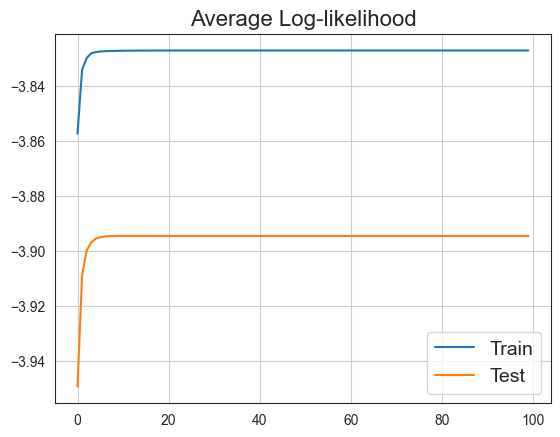

Average log likelihood after convergence of EM on a HMM on the training set:  -3.8270191020737157
Average log likelihood after convergence of EM on a HMM on the test set:  -3.8945980688647284
pi, mu, A, sigma, 


In [24]:
# ---------------------------------------------------------------------------- #
#     Do NOT change the contents of this cell. This is just for execution.     #
#   If you respected function signatures, this cell should run without changes #
# ---------------------------------------------------------------------------- #

# Estimate parameters using EM and collect results
res = exp_max(X_train, X_test, INIT_PARAMS)
pi_em, A_em, mus_em, sigmas_em, train_avg_llike, test_avg_llike = res

# Checks
assert np.all(np.diff(train_avg_llike) >= 0), "The training log-likelihoods of the EM algorithm must be non-decreasing."

# Plot the log-likelihoods
plt.plot(train_avg_llike, label='Train')
plt.plot(test_avg_llike, label='Test')
plt.legend(fontsize=14)
plt.grid(True)
plt.title('Average Log-likelihood', fontsize=16)
plt.show()

print('Average log likelihood after convergence of EM on a HMM on the training set: ', train_avg_llike[-1])
print('Average log likelihood after convergence of EM on a HMM on the test set: ', test_avg_llike[-1])
print('pi, mu, A, sigma, ')

Running the EM algorithm for a GMM with scaled identities covariance matrices and full covariance matrices

Scaled identity covariance matrices


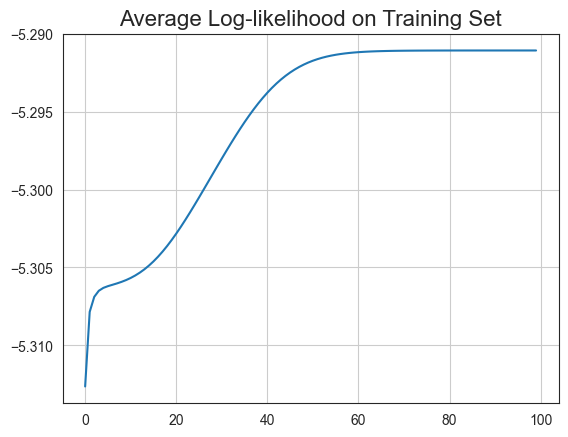

Average log likelihood after convergence of EM on GMM with scaled identities the on training set:  -5.291048676278935
Average log likelihood after convergence of EM on GMM with scaled identities the on test set:  -5.388139083746608

 Full covariance matrix


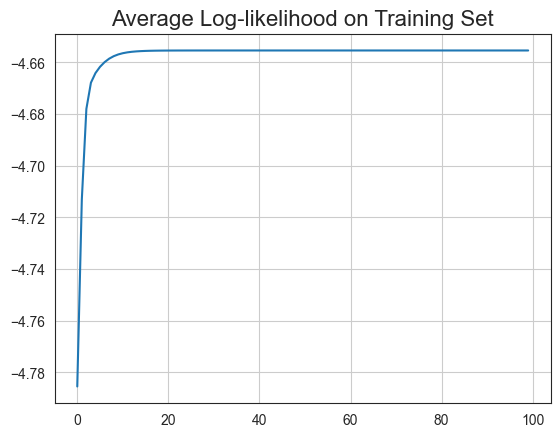

Average log likelihood after convergence of EM on GMM with full covariance after convergence on the training set:  -4.655431349843298
Average log likelihood after convergence of EM on GMM with full covariance after convergence on the test set:  -4.817956307273289


In [323]:
print('Scaled identity covariance matrices')

GMM1 = GaussianMixture(X_train, K=4, use_full_cov=False)
_, avg_llike_train = GMM1[3](X_train)
_, avg_llike_test = GMM1[3](X_test)

print('Average log likelihood after convergence of EM on GMM with scaled identities the on training set: ',avg_llike_train)
print('Average log likelihood after convergence of EM on GMM with scaled identities the on test set: ',avg_llike_test)

print('\n Full covariance matrix')

GMM2 = GaussianMixture(X_train, K=4, use_full_cov=True)
_, avg_llike_train = GMM2[3](X_train)
_, avg_llike_test = GMM2[3](X_test)

print('Average log likelihood after convergence of EM on GMM with full covariance after convergence on the training set: ',avg_llike_train)
print('Average log likelihood after convergence of EM on GMM with full covariance after convergence on the test set: ',avg_llike_test)


Complete the following table with the values of the average log-likelihood for the Gaussian mixture models (with a) scaled identities and b) full covariances) and of the HMM on the train and on the test data.

**Answer:**

Method | Train Avg. Log-Like | Test Avg. Log-Like
--- | --- | ---
*Scaled Identities GMM* |  -5.388| -5.291
*Full Covariance GMM* | -4.655 | -4.818
*Hidden Markov Model* | -3.827 | -3.895


Does it make sense to make this comparison? Why? If so, what conclusions can you draw?. Moreover, briefly compare these log-likelihoods those obtained for the different models in the previous homework.

**Answer:**
Yes it makes sense to compare these models together because they all make different assumptions about the data. In particular, they make assumptions about the independence of the features (temporal dependence) and the structure of the covariance matrices. By comparing their performance we can detect potential dependencies within our data.

In this case, the HMM wildly outperforms the GMMs, hinting to the fact that there is temporal dependencies in the data (so the data is not IID)that the GMMs are not able to capture. Furthermore, it is not overfitting the data because the average log-likelihood is similar for both the training and the test sets (the same is true for the GMMs).

I'm not sure I understand the last question. The log likelihood for the GMMs obtained here are very similar to those I obtained in Hw 3 because we have the same data sets. Again, the HMM is much better than the GMMs, which means that there is most likely a temporal structure in the data.


## Viterbi [20 pts]

### Pseudocode

Provide a description and pseudo-code for the Viterbi decoding algorithm (a.k.a. MAP inference algorithm or max-product algorithm) that estimates the most likely sequence of states: $\arg \max_z p(z_1,\dots,z_T | x_1,\dots,x_T)$.

**Answer:**

**Function** Viterbi(x, pi, A, B, T, K)\
$\qquad$ **input** x: [Txd] sequence of T observations of dimensionality d\
$\qquad$ **input** pi: [1xK] initial state probabilities \
$\qquad$ **input** A: [KxK] transition probabilities matrix \
$\qquad$ **input** B: [TxK] emission probabilities matrix \
$\qquad$ **input** T: scalar: number of observations \
$\qquad$ **input** K: scalar: number of hidden states 

$\qquad$ path $\leftarrow$ TxK matrix of zeros \
$\qquad$ prob $\leftarrow$ TxK matrix of zeros \
$\qquad$ \
$\qquad$ // forward loop \
$\qquad$ **for** k=0 **to** K **do**   
$\qquad$ $\qquad$ prob[0,k] = pi[k] $\times$ B[0, k]  // base case \
$\qquad$ **end** \
$\qquad$ \
$\qquad$ **for** t = 1 **to** T **do** // base case already handled \
$\qquad$ $\qquad$ **for** k=0 **to** K **do** \
$\qquad$ $\qquad$ $\qquad$ **for** i=0 **to** K **do** \
$\qquad$ $\qquad$ $\qquad$ new_prob $\leftarrow$ prob[t-1, i] $\times$ A[i, k] $\times$ B[t, k] \
$\qquad$ $\qquad$ $\qquad$ $\qquad$**if** new_prob > prob[t, k] **then** \
$\qquad$ $\qquad$ $\qquad$ $\qquad$ $\qquad$ prob[t, k] $\leftarrow$ new_prob \
$\qquad$ $\qquad$ $\qquad$ $\qquad$ $\qquad$ path[t, k] $\leftarrow$ i \
$\qquad$ $\qquad$ $\qquad$ $\qquad$ **end** \
$\qquad$ $\qquad$ $\qquad$ **end** \
$\qquad$ $\qquad$ **end** \
$\qquad$ **end** \
$\qquad$ \
$\qquad$ best_path $\leftarrow$ [1xT] array of zeros \
$\qquad$ \
$\qquad$ // backward loop \
$\qquad$ best_path[T-1] $\leftarrow$ $\argmax$ prob[T-1] // base case \
$\qquad$ \
$\qquad$ **for** t=T-2 **to** 0 **inclusive** **do** // base case already handled \
$\qquad$ $\qquad$ best_path[t] $\leftarrow$ path[t+1, best_path[t+1]] \
$\qquad$ **end**\
$\qquad$ \
$\qquad$ **return** best_path \
**end**

### Viterbi implementation

Implement Viterbi decoding.

In [ ]:
def viterbi(X, pi, A, mus, sigmas):
    """
    Viterbi decoding for a time-homogeneous HMM with Gaussian emissions

    Inputs:
        X: [Tx2] matrix of observations
        pi: [Kx1] initial latent state distribution
        A: [KxK] transition matrix
        mus: [Kx2] matrix of latent-conditional emission means
        sigmas: [Kx2x2] tensor of latent-conditional emission covariance matrices

    Returns:
        z: [TxK] one-hot encoding of most probable state sequence z_{1:T} given x_{1:T}
    """

    # useful constants
    T, K = X.shape[0], mus.shape[0]

    B = np.exp(log_emission(X, mus, sigmas)) # emission probabilities 

    # initialization
    path = np.zeros((T, K))
    prob = np.zeros((T, K))

    # forward loop
    for k in range(K):
        prob[0,k] = pi[k] * B[0, k] # base case

    for t in range(1, T): # base case already handled
        new_prob = (prob[t-1] * A.T).T 
        prob[t] = np.max(new_prob, axis = 0) * B[t, :]
        path[t] = np.argmax(new_prob, axis =0)
        prob[t] /= prob[t].sum() # normalization
    

    best_path = np.zeros(T, dtype =int)

    # backward loop
    best_path[-1] = np.argmax(prob[t]) # base case

    for t in reversed(range(T-1)): # base case already handled
        best_path[t] = path[t+1, best_path[t+1]]

    # convert to one-hot encoding
    z = np.zeros((T, K), dtype=int)
    z[np.arange(T), best_path] = 1

    return best_path, z
  

Using the set of parameters learned with the EM algorithm on the **training** set, compute the most likely sequence of states for the **training** data with the Viterbi algorithm. Plot your results.

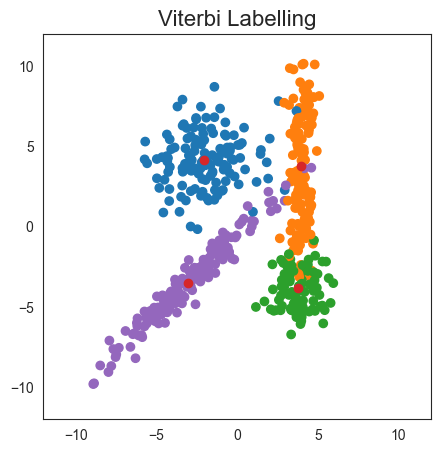

In [25]:
# ---------------------------------------------------------------------------- #
#     Do NOT change the contents of this cell. This is just for execution.     #
#   If you respected function signatures, this cell should run without changes #
# ---------------------------------------------------------------------------- #

# Get one_hot_labels from Viterbi and turn them into 0, ..., K-1 "numeric" labels
_, one_hot_labels = viterbi(X_train, pi_em, A_em, mus_em, sigmas_em)
viterbi_labels =  np.argmax(one_hot_labels, axis=1)

# Plot the results
plot_labelling(X_train, viterbi_labels, mus, 'Viterbi Labelling')

## Comparing methods [20 pts]

Use the parameters learned using EM on the **training** set to compute the smoothing marginal probability $p(z_t|x_1,\dots,x_T)$ for each datapoint in the **test** set to be in state $\{1,2,3,4\}$. Plot the probability of being in that state as a function of time for the 100 first points, as before.

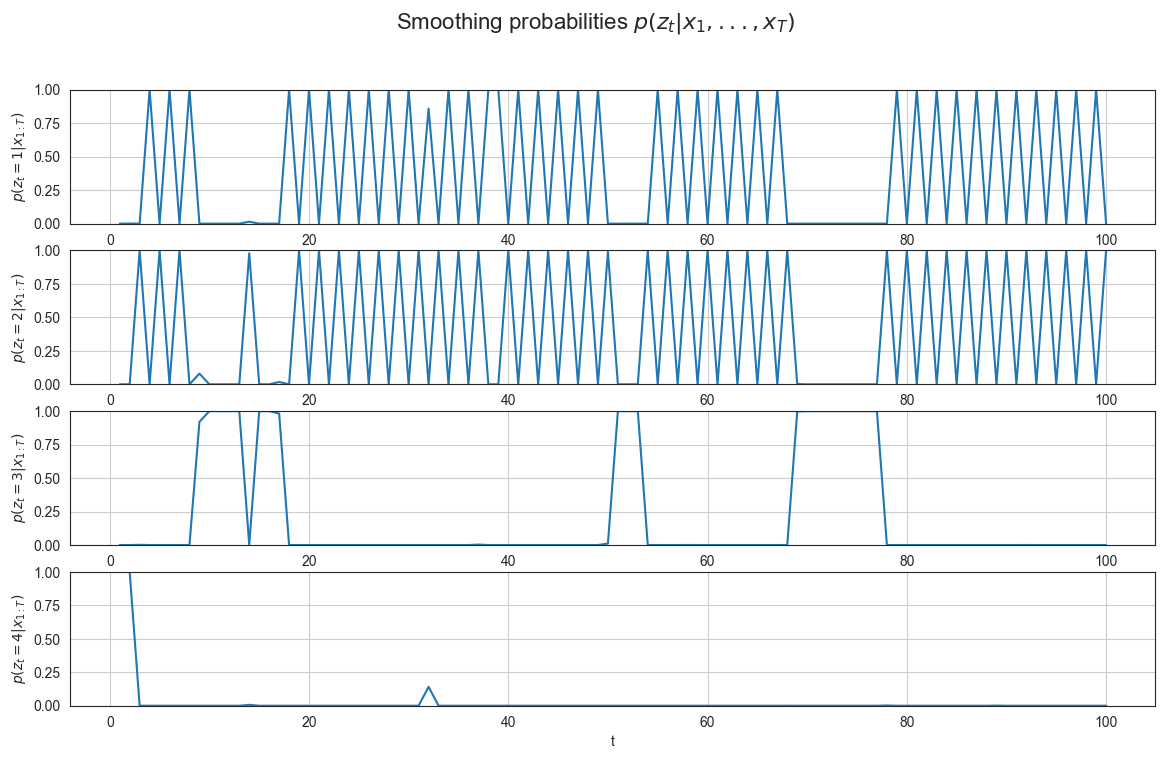

In [26]:
# ---------------------------------------------------------------------------- #
#     Do NOT change the contents of this cell. This is just for execution.     #
#   If you respected function signatures, this cell should run without changes #
# ---------------------------------------------------------------------------- #

# Compute emission (log) probabilities
log_eps = log_emission(X_test, mus_em, sigmas_em)

# Perform (log) alpha and beta recursions
log_alpha = log_alpha_recursion(X_test, A_em, log_eps, pi_em)
log_beta = log_beta_recursion(X_test, A_em, log_eps)

# Compute smoothing probabilities
gamma = smoothing(log_alpha, log_beta)

# Now we do the plot of the smoothing probability for each of the 4 states
plot_smoothing(gamma)

For each of these same 100 points, compute their most likely state according to the marginal probability computed in the previous question. Make a plot representing the most likely state in $\{1,2,3,4\}$ as function of time for these 100 points.

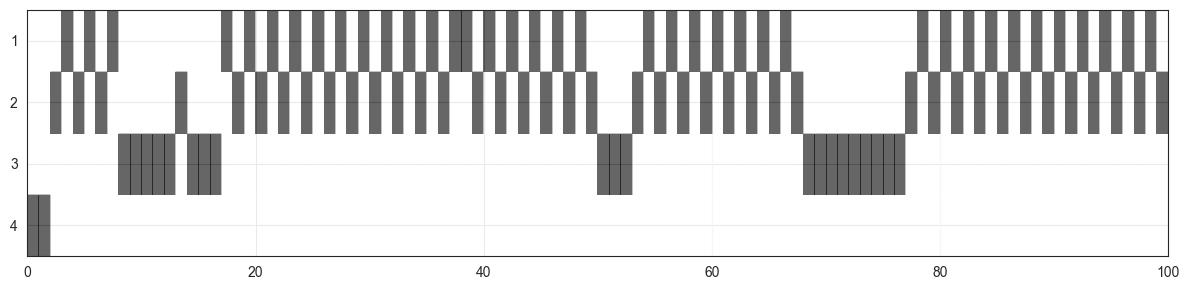

In [27]:
# ---------------------------------------------------------------------------- #
#     Do NOT change the contents of this cell. This is just for execution.     #
#   If you respected function signatures, this cell should run without changes #
# ---------------------------------------------------------------------------- #

plot_dominoes(gamma)

Run Viterbi on the **test** data. Make a similar plot.

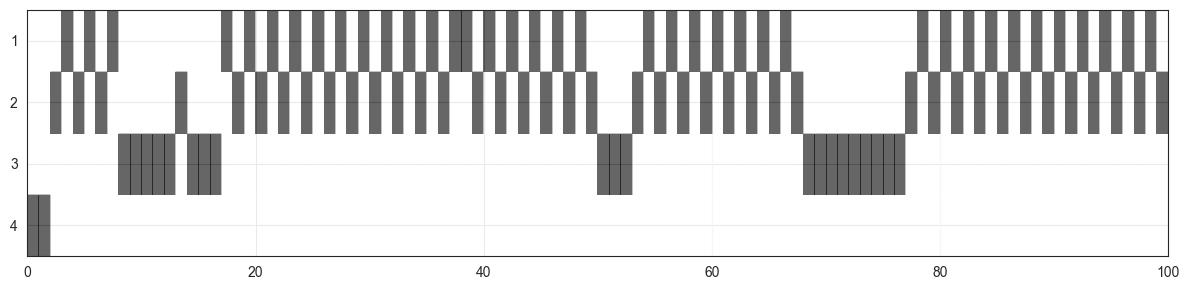

In [28]:
# ---------------------------------------------------------------------------- #
#     Do NOT change the contents of this cell. This is just for execution.     #
#   If you respected function signatures, this cell should run without changes #
# ---------------------------------------------------------------------------- #

# Get one_hot_labels from Viterbi and turn them into 0, ..., K-1 "numeric" labels
_, one_hot_labels = viterbi(X_test, pi_em, A_em, mus_em, sigmas_em)

# Plot the results
plot_dominoes(one_hot_labels)

Compare the most likely sequence of states obtained for the 100 first data points with the sequence of states obtained in the previous question. Comment on your observations.

**Answer:**
The most likely sequence of states according the marginal probabilities and according the Viterbi decoding algorithm are exactly the same. This suggests that the data exhibits temporal dependence and are not IID. The reason is that the Viterbi algorithm considers state transitions over time, and its alignment with the marginal (gamma) indicates that transitions play a significant role in shaping the data.


## What about $K$? [5 pts]

In this problem the number of states $K$ was known. How should one choose the number of states if it is unknown a priori?

**Answer:**
If $K$ is unknown, we can set it as a hyperparameter. We can use a third data set, the validation set, to test out different values of $K$. The value of $K$ that give the best performance on the validation set is the one we should choose. 